In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
import time
import os
import sys
import mat73
from torchsummary import summary

In [7]:
# Set absolute path for the project root directory
PROJECT_ROOT = r'c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression'

# Ensure the project root directory is in the Python path
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify the path settings
print("Current working directory:", os.getcwd())
print("Project root directory:", PROJECT_ROOT)
print("Python path:", sys.path)

# Check if directories exist
expected_dirs = ['src', 'datasets', 'notebooks', 'outputs', 'configs']
for dir_name in expected_dirs:
    dir_path = os.path.join(PROJECT_ROOT, dir_name)
    print(f"'{dir_name}' directory exists:", os.path.exists(dir_path))

# Change working directory to project root
os.chdir(PROJECT_ROOT)
print("\nNew working directory:", os.getcwd())

Current working directory: c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression
Project root directory: c:\Users\WangCo\Documents\ProgramData\Python\radar_interference_suppression
Python path: ['c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311', '', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\WangCo\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\WangCo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages', 'c:\\Users\\WangCo\\Documents\\ProgramData\\Python\\radar_interference_suppressio

In [24]:
import importlib
# import src
from src.utils import analysis
from src.utils import training_validation
from src.utils import evaluation
from src.data import data_utils
from src.utils import visualization
from src.data.dataset import RadarDataset
# from src.models.dualpath_autoencoder import DualPathRadarAutoencoder
from src.models import dualpath_autoencoder
from src.models import baseline_tec
from src.models import ref_conv_autoencoder
from src.training import train_ref_model

In [ ]:

# importlib.reload(src)
importlib.reload(data_utils)
importlib.reload(visualization)
importlib.reload(analysis)
importlib.reload(training_validation)
importlib.reload(evaluation)
importlib.reload(dualpath_autoencoder)

importlib.reload(ref_conv_autoencoder)
importlib.reload(train_ref_model)

print("Modules reloaded successfully!")
# # # Reload the modules to get the latest changes

Modules reloaded successfully!


In [ ]:
scenario_files = [
    os.path.join(PROJECT_ROOT, 'datasets', 'raw', 'train_dataset_2t1_60f.mat')  
]

    # Load and analyze all scenarios
print("Loading scenario data...")
radar_cube, clean_data, scenario_info = data_utils.load_multiple_scenarios(scenario_files)

# DEBUG INFO
print(f"Input shapes - radar_cube: {radar_cube.shape}, clean_data: {clean_data.shape}")
print(f"Data types - radar_cube: {radar_cube.dtype}, clean_data: {clean_data.dtype}")

# Check data values
print("\nData statistics:")
print(f"Radar cube - Mean amplitude: {np.mean(np.abs(radar_cube)):.3f}")
print(f"Radar cube - Max amplitude: {np.max(np.abs(radar_cube)):.3f}")
print(f"Clean data - Mean amplitude: {np.mean(np.abs(clean_data)):.3f}")
print(f"Clean data - Max amplitude: {np.max(np.abs(clean_data)):.3f}")

analysis.analyze_scenario_data(radar_cube, clean_data, scenario_info)

Loading scenario data...

Scenario 1 loaded:
Shape: (256, 128, 60)
Number of frames: 60
[{'scenario_id': 1, 'num_frames': 60, 'shape': (256, 128, 60)}]
Input shapes - radar_cube: (256, 128, 60), clean_data: (256, 128, 60)
Data types - radar_cube: complex128, clean_data: complex128

Data statistics:
Radar cube - Mean amplitude: 0.107
Radar cube - Max amplitude: 0.206
Clean data - Mean amplitude: 0.104
Clean data - Max amplitude: 0.156

Data Analysis Summary:
Total number of scenarios: 1
Total number of frames: 60
Data dimensions: (256, 128, 60)

Scenario 1:
Frames: 60
Input SIR: 10.96 dB


Analyzing original data...

Analyzing Range-Doppler Processing...

Peak Analysis:
Doppler peaks:
Velocity: -48.89 m/s
Velocity: -40.00 m/s

Range peaks:
Range: 19.50 m
Range: 24.00 m


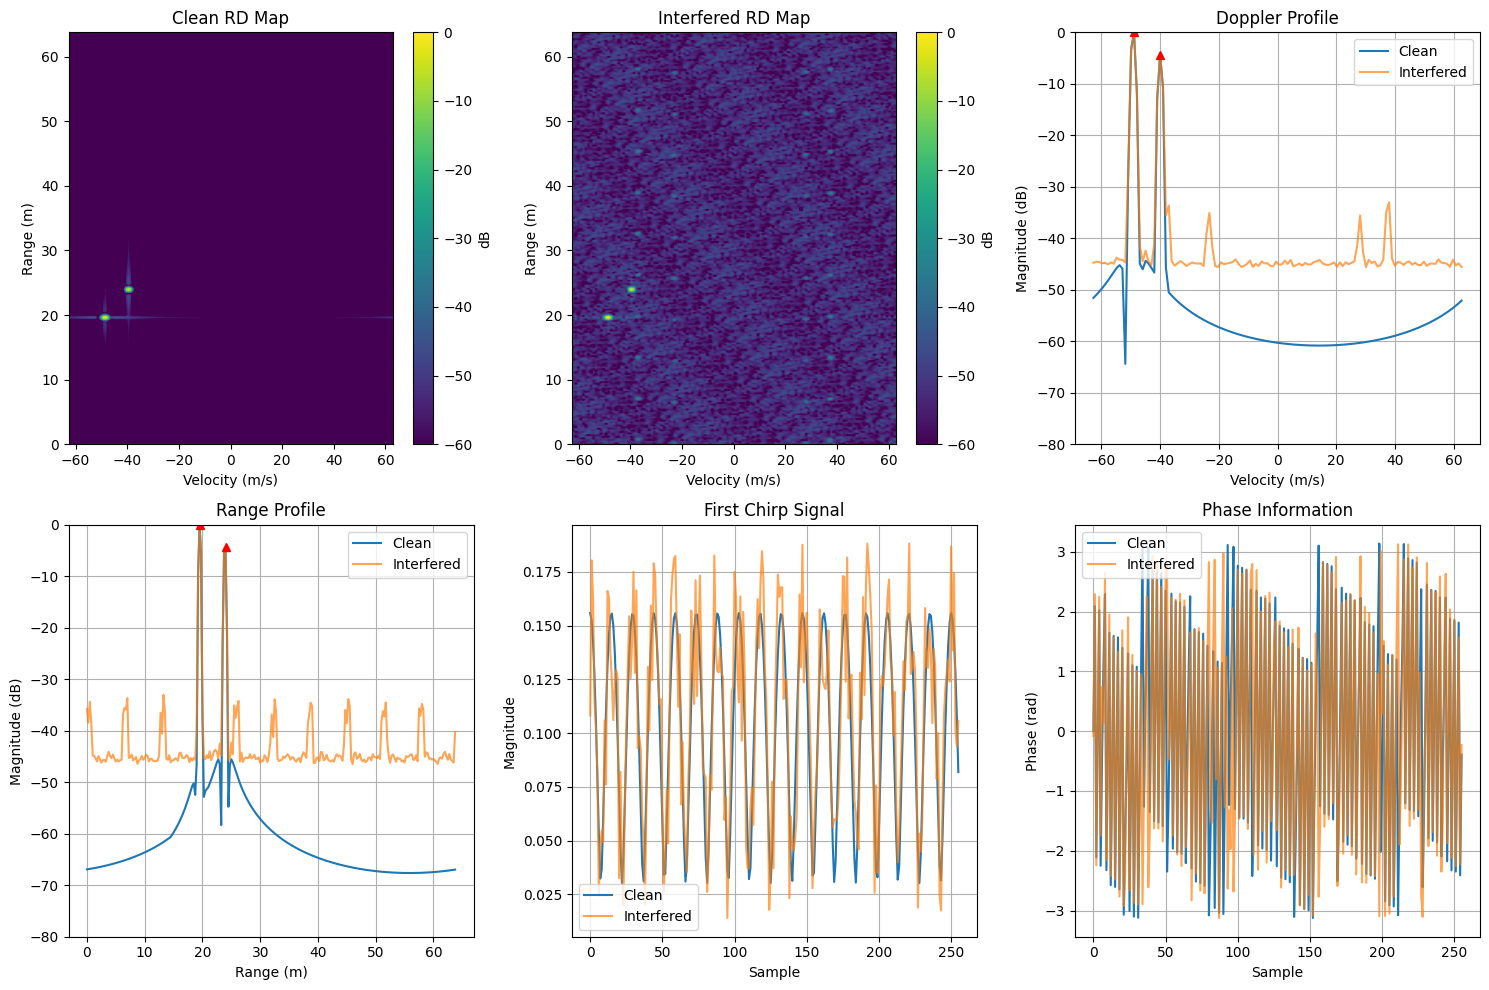

In [ ]:
# Analyze original data
print("Analyzing original data...")
analysis.analyze_rd_processing(radar_cube, clean_data)


In [73]:
# Data preparation
full_dataset = RadarDataset(radar_cube, clean_data)
val_size = int(len(full_dataset) * 0.2)
print(f"size of validation: {val_size}")
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

complex_to_real() triggered:
Real part range: [-0.246, 0.246]
Imag part range: [-0.246, 0.246]
complex_to_real() triggered:
Real part range: [-0.198, 0.198]
Imag part range: [-0.198, 0.198]
Dataset shapes after processing:
Interference data shape: (2, 256, 128, 60)
Clean data shape: (2, 256, 128, 60)
Number of frames: 60
size of validation: 12


In [ ]:
# Training preparation
""""""""" For dual-path autoencoder usage """""""""
# Initialize model
print("Initializing model......")
num_samples, num_chirps = radar_cube.shape[0:2]
# model = dualpath_autoencoder.DualPathRadarAutoencoder(num_samples=num_samples, num_chirps=num_chirps)
model = ref_conv_autoencoder.RefConvAutoencoder()
""""""""" For dual-path autoencoder usage """""""""

# Create dummy inputs for both paths
summary_size = [(2, 256, 128)]  # Both raw and RD map inputs
summary(model, (2, 256, 128))


Initializing model......
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 128]             608
         LeakyReLU-2         [-1, 32, 256, 128]               0
            Conv2d-3         [-1, 32, 256, 128]           9,248
         LeakyReLU-4         [-1, 32, 256, 128]               0
         ConvBlock-5         [-1, 32, 256, 128]               0
         MaxPool2d-6          [-1, 32, 128, 64]               0
            Conv2d-7          [-1, 64, 128, 64]          18,496
         LeakyReLU-8          [-1, 64, 128, 64]               0
            Conv2d-9          [-1, 64, 128, 64]          36,928
        LeakyReLU-10          [-1, 64, 128, 64]               0
        ConvBlock-11          [-1, 64, 128, 64]               0
        MaxPool2d-12           [-1, 64, 64, 32]               0
           Conv2d-13          [-1, 128, 64, 32]          73,856
        LeakyR

In [ ]:
print("\nStarting model training...")
# trained_model, history, memory_usage, training_time = train_ref_model.train_model(
#     model, train_loader, val_loader, num_epochs=50, learning_rate=0.001
# )
trained_model, history = train_ref_model.train_model(
    model, train_loader, val_loader, num_epochs=50, learning_rate=0.001
)


# # Plot history
# visualization.plot_training_history(history)


Starting model training...
Epoch [1/50], Train Loss: 1.089781, Val Loss: 0.419980, LR: 0.001000
Epoch [2/50], Train Loss: 0.322988, Val Loss: 0.197665, LR: 0.001000
Epoch [3/50], Train Loss: 0.146081, Val Loss: 0.108364, LR: 0.001000
Epoch [4/50], Train Loss: 0.076886, Val Loss: 0.070212, LR: 0.001000
Epoch [5/50], Train Loss: 0.056537, Val Loss: 0.055512, LR: 0.001000
Epoch [6/50], Train Loss: 0.045471, Val Loss: 0.048907, LR: 0.001000
Epoch [7/50], Train Loss: 0.042539, Val Loss: 0.044687, LR: 0.001000
Epoch [8/50], Train Loss: 0.040661, Val Loss: 0.044961, LR: 0.001000
Epoch [9/50], Train Loss: 0.039131, Val Loss: 0.044153, LR: 0.001000
Epoch [10/50], Train Loss: 0.038449, Val Loss: 0.042617, LR: 0.001000
Epoch [11/50], Train Loss: 0.039454, Val Loss: 0.041527, LR: 0.001000
Epoch [12/50], Train Loss: 0.037303, Val Loss: 0.040876, LR: 0.001000
Epoch [13/50], Train Loss: 0.035156, Val Loss: 0.040071, LR: 0.001000
Epoch [14/50], Train Loss: 0.034302, Val Loss: 0.039098, LR: 0.001000
E

In [ ]:
importlib.reload(evaluation)
# Evaluate model, get training results
print("\nEvaluating model performance...")
for idx, info in enumerate(scenario_info):
    start_frame = sum(s['num_frames'] for s in scenario_info[:idx])
    scenario_radar = radar_cube[:, :, start_frame:start_frame + info['num_frames']]
    scenario_clean = clean_data[:, :, start_frame:start_frame + info['num_frames']]

    print(f"\nEvaluating Scenario {info['scenario_id']}:")
    # train_results = evaluate_reconstruction(trained_model, scenario_radar, scenario_clean)

    """"""""" For dual-path autoencoder usage """""""""
    # After training
    print("\nEvaluating model performance...")
    # train_results, reconstructed_data = evaluation.evaluate_ref_reconstruction(trained_model, scenario_radar, scenario_clean)
    # train_results, reconstructed_data = evaluation.evaluate_reconstruction_v2(trained_model, scenario_radar, scenario_clean)
    train_results, reconstructed_data = evaluation.evaluate_ref_reconstruction(
    trained_model, 
    scenario_radar, 
    scenario_clean,
    frame_idx=0
)
    """"""""" For dual-path autoencoder usage """""""""

    # reconstructed_cube, train_results = evaluate_and_save_results(
    #     trained_model,
    #     scenario_radar,
    #     scenario_clean
    # )

# Store original metrics
train_ref_metrics_2t1 = train_results
# print(train_metrics)

In [66]:
analysis.compare_metrics(train_ref_metrics_3t1, train_ref_metrics)


Performance Metrics Comparison:
--------------------------------------------------------------------------------
Metric                              Training        Test            Difference     
--------------------------------------------------------------------------------
Detection Probability (%)           1.000           1.000           0.000          
False Alarm Rate (%)                0.000           0.000           0.000          
True Positives                      19              19              0              
False Positives                     0               0               0              
False Negatives                     0               0               0              
--------------------------------------------------------------------------------

Detection Statistics:
--------------------------------------------------------------------------------
Training Set Additional Metrics:
Precision                           1.000
Recall                              1.000